In [39]:
import torch
import torch.nn as nn
from torch.optim import Adam
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Available Device: ", device)


Available Device:  cuda


In [40]:
data_df = pd.read_json('E:/Study/Pytorch_project/text_classification/Sarcasm_Headlines_Dataset.json', lines=True)
data_df.dropna(inplace=True)
data_df.drop_duplicates(inplace=True)
data_df.head(5)

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [41]:
print(data_df.head())
print(data_df.shape)
print(data_df.columns)


                                        article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline  is_sarcastic  
0  former versace store clerk sues over secret 'b...             0  
1  the 'roseanne' revival catches up to our thorn...             0  
2  mom starting to fear son's web series closest ...             1  
3  boehner just wants wife to listen, not come up...             1  
4  j.k. rowling wishes snape happy birthday in th...             0  
(26708, 3)
Index(['article_link', 'headline', 'is_sarcastic'], dtype='object')


In [42]:
data_df.drop(["article_link"],inplace=True, axis=1)

In [43]:
data_df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array(data_df['headline']),
    np.array(data_df['is_sarcastic']),
    test_size=0.3
)


In [45]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

In [47]:
print("Training Size:", X_train.shape[0], "rows, which is:",
      round(X_train.shape[0] / data_df.shape[0] * 100, 2), "%")

print("Validation Size:", X_val.shape[0], "rows, which is:",
      round(X_val.shape[0] / data_df.shape[0] * 100, 2), "%")

print("Testing Size:", X_test.shape[0], "rows, which is:",
      round(X_test.shape[0] / data_df.shape[0] * 100, 2), "%")


Training Size: 18695 rows, which is: 70.0 %
Validation Size: 4006 rows, which is: 15.0 %
Testing Size: 4007 rows, which is: 15.0 %


In [17]:


tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
bert_model = AutoModel.from_pretrained("google-bert/bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [48]:


class dataset(Dataset):
    def __init__(self, X, Y):
        self.X = [
            tokenizer(
                x,
                max_length=100,
                truncation=True,
                padding="max_length",
                return_tensors='pt'
            ).to(device)
            for x in X
        ]
        self.Y = torch.tensor(Y, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


In [49]:
training_data = dataset(X_train, y_train)

validation_data = dataset(X_val, y_val)

testing_data = dataset(X_test, y_test)

In [50]:
BATCH_SIZE =32
EPOCHS = 10
LR =1e-4

In [51]:
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=True)
testing_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle=True)


In [52]:
class MyModel(nn.Module):
    def __init__(self, bert):
        super(MyModel, self).__init__()

        self.bert = bert
        self.dropout = nn.Dropout(0.25)
        self.linear1 = nn.Linear(768, 384)
        self.linear2 = nn.Linear(384, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(input_ids, attention_mask, return_dict=False)[0][:, 0, :]
        output = self.linear1(pooled_output)
        output = self.dropout(output)
        output = self.linear2(output)
        output = self.sigmoid(output)
        return output


In [53]:
for param in bert_model.parameters():
    param.requires_grad = False
model = MyModel(bert_model).to(device)

In [54]:
model

MyModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [55]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(),lr =LR)

In [65]:
from tqdm import tqdm
import torch

EPOCHS = 15
BATCH_SIZE = 32

total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

for epoch in range(EPOCHS):
    print(f"\n===== Epoch {epoch + 1}/{EPOCHS} =====")

    # ---------- TRAINING ----------
    model.train()  # Enable dropout, gradient updates
    total_loss_train = 0
    total_acc_train = 0

    train_loop = tqdm(train_dataloader, desc="Training", leave=False)
    for batch in train_loop:
        inputs, labels = batch

        # Move data to GPU/CPU
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)

        # Forward pass
        predictions = model(inputs["input_ids"].squeeze(1),
                            inputs["attention_mask"].squeeze(1))

        # Compute loss
        batch_loss = criterion(predictions, labels.unsqueeze(1))
        total_loss_train += batch_loss.item()

        # Backward pass
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        # Compute accuracy
        preds = torch.round(predictions)
        acc = (preds == labels.unsqueeze(1)).sum().item()
        total_acc_train += acc

    avg_train_loss = total_loss_train / len(train_dataloader)
    avg_train_acc = total_acc_train / len(training_data)

    # ---------- VALIDATION ----------
    model.eval()  # Disable dropout, no gradient updates
    total_loss_val = 0
    total_acc_val = 0

    val_loop = tqdm(validation_dataloader, desc="Validating", leave=False)
    with torch.no_grad():
        for batch in val_loop:
            inputs, labels = batch
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)

            predictions = model(inputs["input_ids"].squeeze(1),
                                inputs["attention_mask"].squeeze(1))

            batch_loss = criterion(predictions, labels.unsqueeze(1))
            total_loss_val += batch_loss.item()

            preds = torch.round(predictions)
            acc = (preds == labels.unsqueeze(1)).sum().item()
            total_acc_val += acc

    avg_val_loss = total_loss_val / len(validation_dataloader)
    avg_val_acc = total_acc_val / len(validation_data)

    # ---------- TRACK METRICS ----------
    total_loss_train_plot.append(round(avg_train_loss, 4))
    total_loss_val_plot.append(round(avg_val_loss, 4))
    total_acc_train_plot.append(round(avg_train_acc, 4))
    total_acc_val_plot.append(round(avg_val_acc, 4))

    print(f"Epoch {epoch + 1}: "
          f"Train Loss = {avg_train_loss:.4f}, "
          f"Train Acc = {avg_train_acc:.4f}, "
          f"Val Loss = {avg_val_loss:.4f}, "
          f"Val Acc = {avg_val_acc:.4f}")



===== Epoch 1/15 =====


Epoch 1: Train Loss = 0.3796, Train Acc = 0.8353, Val Loss = 0.3439, Val Acc = 0.8480

===== Epoch 2/15 =====


Epoch 2: Train Loss = 0.3783, Train Acc = 0.8341, Val Loss = 0.3343, Val Acc = 0.8575

===== Epoch 3/15 =====


Epoch 3: Train Loss = 0.3723, Train Acc = 0.8386, Val Loss = 0.3310, Val Acc = 0.8572

===== Epoch 4/15 =====


Epoch 4: Train Loss = 0.3723, Train Acc = 0.8388, Val Loss = 0.3288, Val Acc = 0.8630

===== Epoch 5/15 =====


Epoch 5: Train Loss = 0.3742, Train Acc = 0.8363, Val Loss = 0.3288, Val Acc = 0.8615

===== Epoch 6/15 =====


Epoch 6: Train Loss = 0.3699, Train Acc = 0.8391, Val Loss = 0.3219, Val Acc = 0.8610

===== Epoch 7/15 =====


Epoch 7: Train Loss = 0.3729, Train Acc = 0.8374, Val Loss = 0.3243, Val Acc = 0.8582

===== Epoch 8/15 =====


Epoch 8: Train Loss = 0.3706, Train Acc = 0.8404, Val Loss = 0.3196, Val Acc = 0.8674

===== Epoch 9/15 =====


Epoch 9: Train Loss = 0.3675, Train Acc = 0.8399, Val Loss = 0.3224, Val Acc = 0.8650

===== Epoch 10/15 =====


Epoch 10: Train Loss = 0.3637, Train Acc = 0.8441, Val Loss = 0.3150, Val Acc = 0.8640

===== Epoch 11/15 =====


Epoch 11: Train Loss = 0.3693, Train Acc = 0.8386, Val Loss = 0.3202, Val Acc = 0.8575

===== Epoch 12/15 =====


Epoch 12: Train Loss = 0.3736, Train Acc = 0.8365, Val Loss = 0.3213, Val Acc = 0.8669

===== Epoch 13/15 =====


Epoch 13: Train Loss = 0.3621, Train Acc = 0.8432, Val Loss = 0.3183, Val Acc = 0.8602

===== Epoch 14/15 =====


Epoch 14: Train Loss = 0.3715, Train Acc = 0.8385, Val Loss = 0.3276, Val Acc = 0.8652

===== Epoch 15/15 =====


Epoch 15: Train Loss = 0.3659, Train Acc = 0.8418, Val Loss = 0.3185, Val Acc = 0.8617


In [66]:
# ---------- TESTING PHASE ----------
model.eval()  # Set model to evaluation mode
total_loss_test = 0
total_acc_test = 0

with torch.no_grad():  # Disable gradient calculation
    test_loop = tqdm(testing_dataloader, desc="Testing", leave=False)
    for batch in test_loop:
        inputs, labels = batch
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)

        # Forward pass
        predictions = model(inputs["input_ids"].squeeze(1),
                            inputs["attention_mask"].squeeze(1))

        # Compute loss
        batch_loss = criterion(predictions, labels.unsqueeze(1))
        total_loss_test += batch_loss.item()

        # Compute accuracy
        preds = torch.round(predictions)
        acc = (preds == labels.unsqueeze(1)).sum().item()
        total_acc_test += acc

# Average metrics
avg_test_loss = total_loss_test / len(testing_dataloader)
avg_test_acc = total_acc_test / len(testing_data)

print("\n===== TEST RESULTS =====")
print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {avg_test_acc:.4f}")



===== TEST RESULTS =====
Test Loss: 0.3142
Test Accuracy: 0.8577


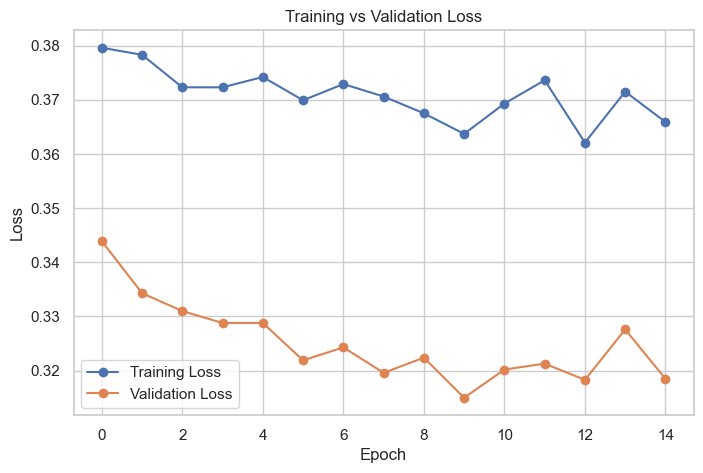

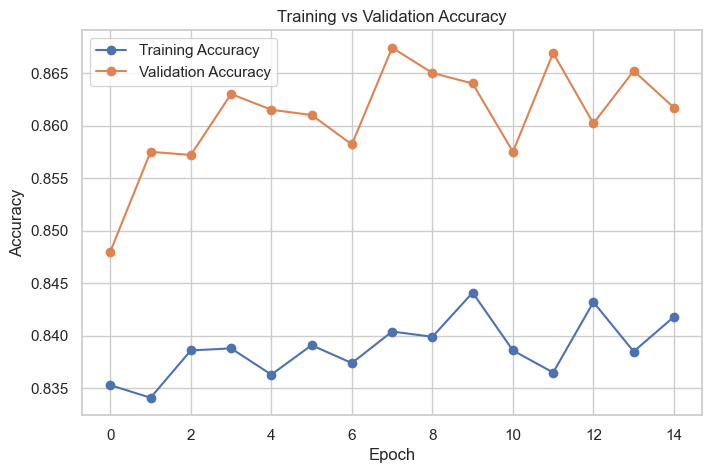

In [67]:
import matplotlib.pyplot as plt

# ---------- LOSS PLOTS ----------
plt.figure(figsize=(8, 5))
plt.plot(total_loss_train_plot, label='Training Loss', marker='o')
plt.plot(total_loss_val_plot, label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# ---------- ACCURACY PLOTS ----------
plt.figure(figsize=(8, 5))
plt.plot(total_acc_train_plot, label='Training Accuracy', marker='o')
plt.plot(total_acc_val_plot, label='Validation Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
